# Deep Learning Project- IA SCHOOL

**This work is the solution of the second winner of a kaggle competition that we have included here as part of a student project whose participants are:**
* Christelle AMOUGOU
* Thanuja RATNASINGAM
* Mounif Alade SANNI
* Flaude BANZA

===========================================================================

**EfficientDet Explained**


What is **EfficientDet** and how does it work?

In short, it is a recent (first submitted at the end of 2019, accepted in CVPR in 2020) very efficient (surprise surprise) object detection model

In more details, it is a family of models designed by researchers from Google brain. The interesting thing is that some parts of it were designed using automatic architecture search, i.e. there was a meta-model that was trained to find the best hyper-parameters of the trained model automatically. Let’s dive in more details.

First, let’s start with the model’s architecture:

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/1400/1*fWcTncW1FRCfR_XgE_8jSg.png", width=900, height=400)

As you can see, there are 3 main building blocks:




1.   a **classification** backbone block
2.   a **multi-scale features** **fusion** block
3.   a **class** and **bounding box networks** block



In more details, we have:




*   an **EfficientNet**(Net and not Det) backbone. This backbone was found using NAS (neural-architecture search) through the use of the MnasNet framework. More on this in the next section
*   **BiFPN** as a multi-scale fusion layer: once we have a classification network we need to efficiently extract features for the detection step. One extra challenge is to do so for multiple scales (learn more about this here). These two challenges are solved efficiently using the BiFPN layer. Again, more on this in the next section.
*   **Two heads**: finally, everything is connected to two output networks. One for predicting the most likely label and one for predicting the detected bounding box (if any).






You can find more details [here](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html)

---------------------------------------

In [ ]:
### Required libraries
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet
from effdet.efficientdet import HeadNet
import random
import os


# Eval Bench Definition (Hidden)

In [ ]:
NMS_THRESHOLD = 0.94

In [ ]:
### Required libraries
import collections
import numpy as np
import torch
import torch.nn as nn
from torchvision.ops.boxes import batched_nms

from effdet.object_detection import argmax_matcher
from effdet.object_detection import box_list
from effdet.object_detection import faster_rcnn_box_coder
from effdet.object_detection import region_similarity_calculator
from effdet.object_detection import target_assigner

# The minimum score to consider a logit for identifying detections.
MIN_CLASS_SCORE = -5.0

# The score for a dummy detection
_DUMMY_DETECTION_SCORE = -1e5

# The maximum number of (anchor,class) pairs to keep for non-max suppression.
MAX_DETECTION_POINTS = 5000

# The maximum number of detections per image.
MAX_DETECTIONS_PER_IMAGE = 100


def decode_box_outputs(rel_codes, anchors, output_xyxy=False):

    """Transforms relative regression coordinates to absolute positions.

    Network predictions are normalized and relative to a given anchor; this
    reverses the transformation and outputs absolute coordinates for the input image.

    Args:
        rel_codes: box regression targets.

        anchors: anchors on all feature levels.

    Returns:
        outputs: bounding boxes.

    """
    ycenter_a = (anchors[0] + anchors[2]) / 2
    xcenter_a = (anchors[1] + anchors[3]) / 2
    ha = anchors[2] - anchors[0]
    wa = anchors[3] - anchors[1]
    ty, tx, th, tw = rel_codes

    w = torch.exp(tw) * wa
    h = torch.exp(th) * ha
    ycenter = ty * ha + ycenter_a
    xcenter = tx * wa + xcenter_a
    ymin = ycenter - h / 2.
    xmin = xcenter - w / 2.
    ymax = ycenter + h / 2.
    xmax = xcenter + w / 2.
    if output_xyxy:
        out = torch.stack([xmin, ymin, xmax, ymax], dim=1)
    else:
        out = torch.stack([ymin, xmin, ymax, xmax], dim=1)
    return out


def _generate_anchor_configs(min_level, max_level, num_scales, aspect_ratios):

    """Generates mapping from output level to a list of anchor configurations.

    A configuration is a tuple of (num_anchors, scale, aspect_ratio).

    Args:
        min_level: integer number of minimum level of the output feature pyramid.

        max_level: integer number of maximum level of the output feature pyramid.

        num_scales: integer number representing intermediate scales added on each level.
            For instances, num_scales=2 adds two additional anchor scales [2^0, 2^0.5] on each level.

        aspect_ratios: list of tuples representing the aspect ratio anchors added on each level.
            For instances, aspect_ratios = [(1, 1), (1.4, 0.7), (0.7, 1.4)] adds three anchors on each level.

    Returns:
        anchor_configs: a dictionary with keys as the levels of anchors and
            values as a list of anchor configuration.
    """

    anchor_configs = {}
    for level in range(min_level, max_level + 1):
        anchor_configs[level] = []
        for scale_octave in range(num_scales):
            for aspect in aspect_ratios:
                anchor_configs[level].append((2 ** level, scale_octave / float(num_scales), aspect))
    return anchor_configs


def _generate_anchor_boxes(image_size, anchor_scale, anchor_configs):

    """Generates multiscale anchor boxes.

    Args:
        image_size: integer number of input image size. The input image has the same dimension for
            width and height. The image_size should be divided by the largest feature stride 2^max_level.

        anchor_scale: float number representing the scale of size of the base
            anchor to the feature stride 2^level.

        anchor_configs: a dictionary with keys as the levels of anchors and
            values as a list of anchor configuration.

    Returns:
        anchor_boxes: a numpy array with shape [N, 4], which stacks anchors on all feature levels.

    Raises:
        ValueError: input size must be the multiple of largest feature stride.
    """

    boxes_all = []
    for _, configs in anchor_configs.items():
        boxes_level = []
        for config in configs:
            stride, octave_scale, aspect = config
            if image_size % stride != 0:
                raise ValueError("input size must be divided by the stride.")
            base_anchor_size = anchor_scale * stride * 2 ** octave_scale
            anchor_size_x_2 = base_anchor_size * aspect[0] / 2.0
            anchor_size_y_2 = base_anchor_size * aspect[1] / 2.0

            x = np.arange(stride / 2, image_size, stride)
            y = np.arange(stride / 2, image_size, stride)
            xv, yv = np.meshgrid(x, y)
            xv = xv.reshape(-1)
            yv = yv.reshape(-1)

            boxes = np.vstack((yv - anchor_size_y_2, xv - anchor_size_x_2,
                               yv + anchor_size_y_2, xv + anchor_size_x_2))
            boxes = np.swapaxes(boxes, 0, 1)
            boxes_level.append(np.expand_dims(boxes, axis=1))

        # concat anchors on the same level to the reshape NxAx4
        boxes_level = np.concatenate(boxes_level, axis=1)
        boxes_all.append(boxes_level.reshape([-1, 4]))

    anchor_boxes = np.vstack(boxes_all)
    return anchor_boxes


def generate_detections(cls_outputs, box_outputs, anchor_boxes, indices, classes, image_scale):

    """Generates detections with RetinaNet model outputs and anchors.

    Args:
        cls_outputs: a torch tensor with shape [N, 1], which has the highest class
            scores on all feature levels. The N is the number of selected
            top-K total anchors on all levels.  (k being MAX_DETECTION_POINTS)

        box_outputs: a torch tensor with shape [N, 4], which stacks box regression
            outputs on all feature levels. The N is the number of selected top-k
            total anchors on all levels. (k being MAX_DETECTION_POINTS)

        anchor_boxes: a torch tensor with shape [N, 4], which stacks anchors on all
            feature levels. The N is the number of selected top-k total anchors on all levels.

        indices: a torch tensor with shape [N], which is the indices from top-k selection.

        classes: a torch tensor with shape [N], which represents the class
            prediction on all selected anchors from top-k selection.

        image_scale: a float tensor representing the scale between original image
            and input image for the detector. It is used to rescale detections for
            evaluating with the original groundtruth annotations.

    Returns:
        detections: detection results in a tensor with shape [MAX_DETECTION_POINTS, 6],
            each row representing [x, y, width, height, score, class]
    """

    anchor_boxes = anchor_boxes[indices, :]

    # apply bounding box regression to anchors
    boxes = decode_box_outputs(box_outputs.T.float(), anchor_boxes.T, output_xyxy=True)

    scores = cls_outputs.sigmoid().squeeze(1).float()
    top_detection_idx = batched_nms(boxes, scores, classes, iou_threshold=NMS_THRESHOLD)

    # keep only topk scoring predictions
    top_detection_idx = top_detection_idx[:MAX_DETECTIONS_PER_IMAGE]
    boxes = boxes[top_detection_idx]
    scores = scores[top_detection_idx, None]
    classes = classes[top_detection_idx, None]

    # xyxy to xywh & rescale to original image
    boxes[:, 2] -= boxes[:, 0]
    boxes[:, 3] -= boxes[:, 1]
    boxes *= image_scale

    classes += 1  # back to class idx with background class = 0

    # stack em and pad out to MAX_DETECTIONS_PER_IMAGE if necessary
    detections = torch.cat([boxes, scores, classes.float()], dim=1)
    if len(top_detection_idx) < MAX_DETECTIONS_PER_IMAGE:
        detections = torch.cat([
            detections,
            torch.zeros(
                (MAX_DETECTIONS_PER_IMAGE - len(top_detection_idx), 6), device=detections.device, dtype=detections.dtype)
        ], dim=0)
    return detections

####RetinaNet Anchors class
class Anchors(nn.Module):

    def __init__(self, min_level, max_level, num_scales, aspect_ratios, anchor_scale, image_size):

        """Constructs multiscale RetinaNet anchors.

        Args:
            min_level: integer number of minimum level of the output feature pyramid.

            max_level: integer number of maximum level of the output feature pyramid.

            num_scales: integer number representing intermediate scales added
                on each level. For instances, num_scales=2 adds two additional
                anchor scales [2^0, 2^0.5] on each level.

            aspect_ratios: list of tuples representing the aspect ratio anchors added
                on each level. For instances, aspect_ratios =
                [(1, 1), (1.4, 0.7), (0.7, 1.4)] adds three anchors on each level.

            anchor_scale: float number representing the scale of size of the base
                anchor to the feature stride 2^level.

            image_size: integer number of input image size. The input image has the
                same dimension for width and height. The image_size should be divided by
                the largest feature stride 2^max_level.
        """
        super(Anchors, self).__init__()
        self.min_level = min_level
        self.max_level = max_level
        self.num_scales = num_scales
        self.aspect_ratios = aspect_ratios
        self.anchor_scale = anchor_scale
        self.image_size = image_size
        self.config = self._generate_configs()
        self.register_buffer('boxes', self._generate_boxes())

    def _generate_configs(self):
        """Generate configurations of anchor boxes."""
        return _generate_anchor_configs(self.min_level, self.max_level, self.num_scales, self.aspect_ratios)

    def _generate_boxes(self):
        """Generates multiscale anchor boxes."""
        boxes = _generate_anchor_boxes(self.image_size, self.anchor_scale, self.config)
        boxes = torch.from_numpy(boxes).float()
        return boxes

    def get_anchors_per_location(self):
        return self.num_scales * len(self.aspect_ratios)


##### FIXME PyTorch port of this class and subclasses not tested yet, needed for training
class AnchorLabeler(nn.Module):
    """Labeler for multiscale anchor boxes.
    """

    def __init__(self, anchors, num_classes, match_threshold=0.5):
        """Constructs anchor labeler to assign labels to anchors.

        Args:
            anchors: an instance of class Anchors.

            num_classes: integer number representing number of classes in the dataset.

            match_threshold: float number between 0 and 1 representing the threshold
                to assign positive labels for anchors.
        """
        super(AnchorLabeler, self).__init__()
        similarity_calc = region_similarity_calculator.IouSimilarity()
        matcher = argmax_matcher.ArgMaxMatcher(
            match_threshold,
            unmatched_threshold=match_threshold,
            negatives_lower_than_unmatched=True,
            force_match_for_each_row=True)
        box_coder = faster_rcnn_box_coder.FasterRcnnBoxCoder()

        self.target_assigner = target_assigner.TargetAssigner(similarity_calc, matcher, box_coder)
        self.anchors = anchors
        self.match_threshold = match_threshold
        self.num_classes = num_classes

    def _unpack_labels(self, labels):
        """Unpacks an array of labels into multiscales labels."""
        labels_unpacked = []
        anchors = self.anchors
        count = 0
        for level in range(anchors.min_level, anchors.max_level + 1):
            feat_size = int(anchors.image_size / 2 ** level)
            steps = feat_size ** 2 * anchors.get_anchors_per_location()
            indices = torch.arange(count, count + steps, device=labels.device)
            count += steps
            labels_unpacked.append(
                torch.index_select(labels, 0, indices).view([feat_size, feat_size, -1]))
        return labels_unpacked

    def label_anchors(self, gt_boxes, gt_labels):

        """Labels anchors with ground truth inputs.

        Args:
            gt_boxes: A float tensor with shape [N, 4] representing groundtruth boxes.
                For each row, it stores [y0, x0, y1, x1] for four corners of a box.

            gt_labels: A integer tensor with shape [N, 1] representing groundtruth classes.

        Returns:
            cls_targets_dict: ordered dictionary with keys [min_level, min_level+1, ..., max_level].
                The values are tensor with shape [height_l, width_l, num_anchors]. The height_l and width_l
                represent the dimension of class logits at l-th level.

            box_targets_dict: ordered dictionary with keys [min_level, min_level+1, ..., max_level].
                The values are tensor with shape [height_l, width_l, num_anchors * 4]. The height_l and
                width_l represent the dimension of bounding box regression output at l-th level.

            num_positives: scalar tensor storing number of positives in an image.
        """
        gt_box_list = box_list.BoxList(gt_boxes)
        anchor_box_list = box_list.BoxList(self.anchors.boxes)

        ##### cls_weights, box_weights are not used
        cls_targets, _, box_targets, _, matches = self.target_assigner.assign(anchor_box_list, gt_box_list, gt_labels)

        ##### class labels start from 1 and the background class = -1
        cls_targets -= 1
        cls_targets = cls_targets.long()

        ##### Unpack labels.
        cls_targets_dict = self._unpack_labels(cls_targets)
        box_targets_dict = self._unpack_labels(box_targets)
        num_positives = (matches.match_results != -1).float().sum()

        return cls_targets_dict, box_targets_dict, num_positives



""" PyTorch EfficientDet support benches

Hacked together by Ross Wightman
"""
import torch
import torch.nn as nn

#from .anchors import Anchors, AnchorLabeler, generate_detections, MAX_DETECTION_POINTS
from effdet.loss import DetectionLoss


def _post_process(config, cls_outputs, box_outputs):
    """Selects top-k predictions.

    Post-proc code adapted from Tensorflow version at: https://github.com/google/automl/tree/master/efficientdet
    and optimized for PyTorch.

    Args:
        config: a parameter dictionary that includes `min_level`, `max_level`,  `batch_size`, and `num_classes`.

        cls_outputs: an OrderDict with keys representing levels and values
            representing logits in [batch_size, height, width, num_anchors].

        box_outputs: an OrderDict with keys representing levels and values
            representing box regression targets in [batch_size, height, width, num_anchors * 4].
    """
    batch_size = cls_outputs[0].shape[0]
    cls_outputs_all = torch.cat([
        cls_outputs[level].permute(0, 2, 3, 1).reshape([batch_size, -1, config.num_classes])
        for level in range(config.num_levels)], 1)

    box_outputs_all = torch.cat([
        box_outputs[level].permute(0, 2, 3, 1).reshape([batch_size, -1, 4])
        for level in range(config.num_levels)], 1)

    _, cls_topk_indices_all = torch.topk(cls_outputs_all.reshape(batch_size, -1), dim=1, k=MAX_DETECTION_POINTS)
    indices_all = cls_topk_indices_all / config.num_classes
    classes_all = cls_topk_indices_all % config.num_classes

    box_outputs_all_after_topk = torch.gather(
        box_outputs_all, 1, indices_all.unsqueeze(2).expand(-1, -1, 4))

    cls_outputs_all_after_topk = torch.gather(
        cls_outputs_all, 1, indices_all.unsqueeze(2).expand(-1, -1, config.num_classes))
    cls_outputs_all_after_topk = torch.gather(
        cls_outputs_all_after_topk, 2, classes_all.unsqueeze(2))

    return cls_outputs_all_after_topk, box_outputs_all_after_topk, indices_all, classes_all


class DetBenchEval(nn.Module):
    def __init__(self, model, config):
        super(DetBenchEval, self).__init__()
        self.config = config
        self.model = model
        self.anchors = Anchors(
            config.min_level, config.max_level,
            config.num_scales, config.aspect_ratios,
            config.anchor_scale, config.image_size)

    def forward(self, x, image_scales):
        class_out, box_out = self.model(x)
        class_out, box_out, indices, classes = _post_process(self.config, class_out, box_out)

        batch_detections = []

        ##### FIXME we may be able to do this as a batch with some tensor reshaping/indexing, PR welcome
        for i in range(x.shape[0]):
            detections = generate_detections(
                class_out[i], box_out[i], self.anchors.boxes, indices[i], classes[i], image_scales[i])
            batch_detections.append(detections)
        return torch.stack(batch_detections, dim=0)


class DetBenchTrain(nn.Module):
    def __init__(self, model, config):
        super(DetBenchTrain, self).__init__()
        self.config = config
        self.model = model
        anchors = Anchors(
            config.min_level, config.max_level,
            config.num_scales, config.aspect_ratios,
            config.anchor_scale, config.image_size)
        self.anchor_labeler = AnchorLabeler(anchors, config.num_classes, match_threshold=0.5)
        self.loss_fn = DetectionLoss(self.config)

    def forward(self, x, gt_boxes, gt_labels):
        class_out, box_out = self.model(x)

        cls_targets = []
        box_targets = []
        num_positives = []

        ##### FIXME this may be a bottleneck, would be faster if batched, or should be done in loader/dataset?
        for i in range(x.shape[0]):
            gt_class_out, gt_box_out, num_positive = self.anchor_labeler.label_anchors(gt_boxes[i], gt_labels[i])
            cls_targets.append(gt_class_out)
            box_targets.append(gt_box_out)
            num_positives.append(num_positive)

        return self.loss_fn(class_out, box_out, cls_targets, box_targets, num_positives)


# Hyperparameters

In [ ]:
# images size is 1024 * 1024 - (3 channels R, G, B)
SIZE = 1024

# paths of the pre trained weight of the efficientdet model
WEIGHT_FILE1 = '../input/effdet5fold/stac2.bin'
WEIGHT_FILE2 = '../input/effdet5fold/splitbn.bin'

# initialisation of the IOU metric parameters
STAGE1_THRESHOLD = 0.25
STAGE1_IOU_THR = 0.475
STAGE1_SKIP_THR = 0.41

STAGE1_SUPPRESS = 0.125

STAGE2_THRESHOLD = 0.37
STAGE2_IOU_THR = 0.44
STAGE2_SKIP_THR = 0.43

STAGE2_SUPPRESS = 0.125

MAX_BOX = 240  ## the maximum boxes used
MIN_BOX = 10   ### the minimum boxes used

EPOCHS_1 = 13 ## number of training epoch for the first model
EPOCHS_2 = 13 ## number of training epoch for second model

# WBF Source Code (Hidden) Weighted Boxes Fusion
Both NMS and Soft-NMS exclude some boxes, but WBF uses information from all boxes. It can fix some cases where all boxes are predicted inaccurate by all models. NMS will leave only one inaccurate box, while WBF will fix it using information from all 3 boxes (see the example in Fig. 1, red predictions, blue ground truth).
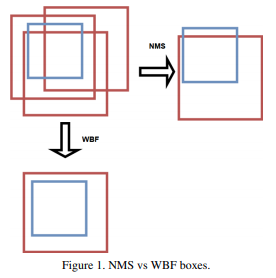


In [ ]:
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'


import warnings
import numpy as np
from numba import jit


@jit(nopython=True)
def bb_intersection_over_union(A, B) -> float:
    # determine the (x, y)-coordinates of the intersection rectangle
    #We will be defining a box using its two corners (upper left and lower right). The coordinates can be named as (x1,y1,x2,y2).
    #We will also have to find out the coordinates of the intersection of two boxes.
    #xA: maximum of the x1 coordinates of the two boxes.
    #yA: maximum of the y1 coordinates of the two boxes.
    #xB: minimum of the x2 coordinates of the two boxes.
    #yB: minimum of the y2 coordinates of the two boxes.

    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    ##### compute the area of intersection rectangle
    #The area of the rectangle formed after intersection can be calculated as: (xB — xA)*(yB — yA)
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    ##### compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])
    

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area

    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    center_x1 = (A[2] + A[0]) / 2
    center_y1 = (A[3] + A[1]) / 2
    center_x2 = (B[2] + B[0]) / 2
    center_y2 = (B[3] + B[1]) / 2
    d_2 = (center_x1 - center_x2) ** 2 + (center_y1 - center_y2) ** 2
    c_2 = (max(A[2], B[2]) - min(A[0], B[0])) ** 2 + (
            max(A[3], B[3]) - min(A[1], B[1])) ** 2
    
    d_iou = max(min(iou - d_2 / c_2, 1),-1)
    
    # return the intersection over union value
    return d_iou

def prefilter_boxes(boxes, scores, labels, weights, thr):

    ##### Create dict with boxes stored by its label
    new_boxes = dict()

    for t in range(len(boxes)):
        # must have as many boxes as scores - each predicted boxes with his score
        if len(boxes[t]) != len(scores[t]):
            print('Error. Length of boxes arrays not equal to length of scores array: {} != {}'.format(len(boxes[t]), len(scores[t])))
            exit()
         # same for the boxes lables
        if len(boxes[t]) != len(labels[t]):
            print('Error. Length of boxes arrays not equal to length of labels array: {} != {}'.format(len(boxes[t]), len(labels[t])))
            exit()

        # thr is the threshold of the IoU model for whether the prediction is a true positive of false positive
        # if score > thr true positive and if score < thr false positive
        # the model does not return predictions with a score < thr   

        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            b = [int(label), float(score) * weights[t], float(box_part[0]), float(box_part[1]), float(box_part[2]), float(box_part[3])]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

            ##### Box data checks
            if x2 < x1:
                warnings.warn('X2 < X1 value in box. Swap them.')
                x1, x2 = x2, x1
            if y2 < y1:
                warnings.warn('Y2 < Y1 value in box. Swap them.')
                y1, y2 = y2, y1
            if x1 < 0:
                warnings.warn('X1 < 0 in box. Set it to 0.')
                x1 = 0
            if x1 > 1:
                warnings.warn('X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x1 = 1
            if x2 < 0:
                warnings.warn('X2 < 0 in box. Set it to 0.')
                x2 = 0
            if x2 > 1:
                warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x2 = 1
            if y1 < 0:
                warnings.warn('Y1 < 0 in box. Set it to 0.')
                y1 = 0
            if y1 > 1:
                warnings.warn('Y1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y1 = 1
            if y2 < 0:
                warnings.warn('Y2 < 0 in box. Set it to 0.')
                y2 = 0
            if y2 > 1:
                warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y2 = 1
            if (x2 - x1) * (y2 - y1) == 0.0:
                warnings.warn("Zero area box skipped: {}.".format(box_part))
                continue

            # add news box to the dict
            b = [int(label), float(score) * weights[t], x1, y1, x2, y2]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    ##### Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box
    """

    box = np.zeros(6, dtype=np.float32)
    conf = 0
    conf_list = []
    for b in boxes:
        box[2:] += (b[1] * b[2:])
        conf += b[1]
        conf_list.append(b[1])
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    box[2:] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        # compute the iou score of the boxes
        iou = bb_intersection_over_union(box[2:], new_box[2:])
        # keep the best iou score
        if iou > best_iou:
            best_index = i
            best_iou = iou
   
   # return the box with the best iou score
    return best_index, best_iou


def weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers.
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param iou_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value
    :param allows_overflow: false if we want confidence score not exceed 1.0
    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2).
    :return: scores: confidence scores
    :return: labels: boxes labels
    '''
   # put boxes weights to 1
    if weights is None:
        weights = np.ones(len(boxes_list))
    # must have same lenght for weight list and boxes list
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        # adapt the len
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max']:
        print('Unknown conf_type: {}. Must be "avg" or "max"'.format(conf_type))
        exit()

# filter boxes and keep only boxes who have a good iou score
# use of prefilter_boxes function defined above
    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,))

    overall_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = []

        ##### Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box(weighted_boxes, boxes[j], iou_thr)
            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes.append(boxes[j].copy())### Eval Bench Definition (Hidden)

        ##### Rescale confidence based on number of models and boxes
        for i in range(len(new_boxes)):
            if not allows_overflow:
                weighted_boxes[i][1] = weighted_boxes[i][1] * min(weights.sum(), len(new_boxes[i])) / weights.sum()
            else:
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(new_boxes[i]) / weights.sum()
        overall_boxes.append(np.array(weighted_boxes))

    overall_boxes = np.concatenate(overall_boxes, axis=0)
    overall_boxes = overall_boxes[overall_boxes[:, 1].argsort()[::-1]]
    boxes = overall_boxes[:, 2:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    return boxes, scores, labels

In [ ]:
# Declare an augmentation pipeline with the Albumentations library
# Albumentations is a fast and flexible image augmentation library

# resize the input to the given height and width - desired height and width of the output
# p is the probability of applying the transform

def get_valid_transforms():
    return A.Compose([
            A.Resize(height=SIZE, width=SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [ ]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

Mise en place du modèle EfficientDet , variante D6

In [ ]:
def load_net(checkpoint_path):
    # get the EfficientDet D6 config
    config = get_efficientdet_config('tf_efficientdet_d6')
    # create the model
    net = EfficientDet(config, pretrained_backbone=False)

    # change the number of class to 1 (only prerdicting wheat) and define the image size
    config.num_classes = 1
    config.image_size=SIZE
    
    # Add the head with the updated parameters and attach it to the model - can be done on two step
    # 1- define head variable : head = HeadNet(...)
    # 2- attach the head : net.class_net = head
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    # load pretrained weights
    checkpoint = torch.load(checkpoint_path)
    
    newc = {}
    for k,v in checkpoint['model_state_dict'].items():
        if 'aux_bn' not in k:
            newc[k] = v
    net.load_state_dict(newc)
    
    # delete loaded weights to avoid the accululation
    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

# pre trained weight assignment to the model
net = load_net(WEIGHT_FILE1)

# TTA Code (Hidden)

In [ ]:
'''''
Data Augmentation is the process of randomly applying some operations (rotation, zoom, shift, flips,…) to the input data. By this mean, the model is 
never shown twice the exact same example and has to learn more general features about the classes he has to recognize.
Similar to what Data Augmentation is doing to the training set, the purpose of Test Time Augmentation (TTA) is to perform random modifications to the test
images. Thus, instead of showing the regular, “clean” images, only once to the trained model. Test Time Augmentation is particularly useful for test images that the model is pretty unsure.

here the author made a data Augmentation through the image, the boxes and the batch
after he did a TTA on Horizontal Flip, Vertical Flip, rotation(90, 180, 270) and compose.
'''''
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = SIZE

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [ ]:
''''
itertools is a module in Python that facilitates working on iterators in order to produce more complex and efficient iterators via functions.
The module is known to be memory efficient and time-saving in the field of iterator algebra. One might use itertools on the same iterator or in combination to form iterator algebra. 

''''


from itertools import product

tta_combinations = [[TTARotate270()],[None],[TTARotate90()],[TTARotate180()],[TTAVerticalFlip(),TTARotate270()],[TTAVerticalFlip(),TTARotate90()],[TTAVerticalFlip()],[TTAHorizontalFlip()] ]

tta_transforms = []
for tta_combination in tta_combinations:
    print([tta_transform for tta_transform in tta_combination if tta_transform])
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

[]
[<__main__.TTAVerticalFlip object at 0x7f2d2d430050>, <__main__.TTARotate270 object at 0x7f2d2d4300d0>]
[<__main__.TTAVerticalFlip object at 0x7f2d2d430110>, <__main__.TTARotate90 object at 0x7f2d2d4301d0>]


In [ ]:
len(tta_transforms)

8

In [ ]:
def make_tta_predictions(images, score_threshold=STAGE1_THRESHOLD):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
        del images
        gc.collect()
    return predictions

def run_wbf(predictions, image_index, image_size=SIZE, iou_thr=STAGE1_IOU_THR, skip_box_thr=STAGE1_SKIP_THR, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    if (len(boxes)==0): return boxes, scores, labels
    try:
        boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    except:
        return [], [], []
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

# Generating Pseudo-Labels

Pseudo labelling

There are 4,000 original images and further analysis revealed that: not only is the data small, the ears of wheat often overlap, the ears of wheat have several sizes, and the appearance and color of the wheat varies due to of different maturity.
For a noisy dataset, it is inherently impossible to find a good validation strategy. We can only judge the results reluctantly.
It is normal for the accuracy rate to fluctuate less than 1%, we can be confident that 0.75 is better than 0.74, but if the result falls in the middle, then the actual situation is actually very insignificant, which means that it is impossible to judge which result is better.
At the same time, empirical experience says that the target detection competition has never been better than the quality of an adaptation model that you can train based on existing data, but to train a model that works best on the test set.
This implies a sense: when the train set and the test set do not come from the same distribution, such as excessive noise, the best generated model does not necessarily mean the best performance on the test set. This is why a pseudo-tagging is used in this task which is needed.
Besides the benefits of self-training to improve generalization abilities, it can also help us spy on the distribution of the testset.

This is a semi-supervised learning technique that can help when we have a small amount of labeled data and lots of unlabelled data. When we train a model on a small set of data, it won't be robust. Also labeling the large set of data would take a lot of time and money. So what we can do is we can train the model on the available small labeled dataset and then use that model to predict the label on the unlabeled dataset(this label is called pseudo-label). Then again train the model with both labeled data and pseudo-labeled data. This will make the model more robust.

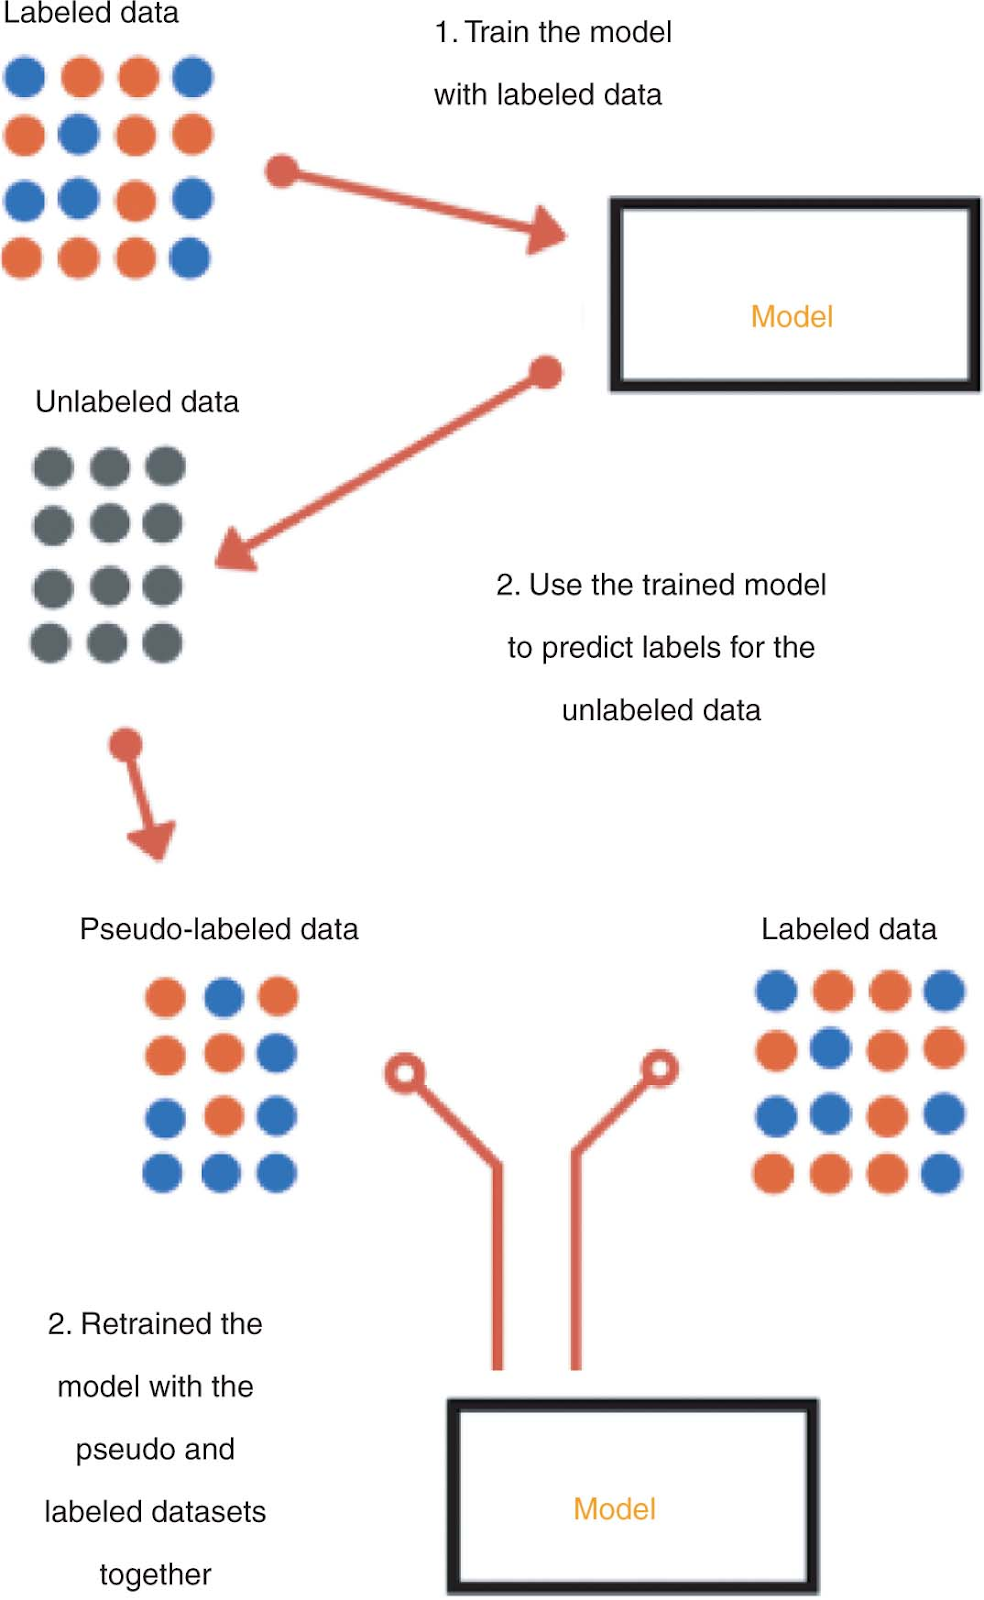

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("[{1}, {2}, {3}, {4}]".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return pred_strings

In [ ]:
from tqdm import tqdm

results = []

# Create pseudo label dataframe for unlabeled images
#Draws detections in an image.




for images, image_ids in tqdm(data_loader):
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        # run network
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        
        boxes = (boxes).round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        # score_threshold : Threshold used for determining what detections to draw.
        score_threshold = STAGE1_SUPPRESS
        indexes = np.where(scores>score_threshold)

        # # select those detections
        boxes = boxes[indexes]
        scores = scores[indexes]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        bboxes = (format_prediction_string(boxes, scores))
        for bbox in bboxes:
            result = {
                'image_id': image_id,
                'width': 1024,
                'height': 1024,
                'bbox': bbox,
                'source': 'pseudo'
            }
            results.append(result)

  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1591914880026/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: X1 < 0 in box. Set it to 0.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Y1 < 0 in box. Set it to 0.
/opt

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'width', 'height', 'bbox', 'source'])
test_df.to_csv('pseudo.csv', index=False)
test_df.head()
print(len(test_df))

272


In [ ]:
del net
import gc
gc.collect()

564

# Pseudo-Labels for Model 2

In [ ]:
net = load_net(WEIGHT_FILE2)

results = []

for images, image_ids in tqdm(data_loader):
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        # run network
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        
        boxes = (boxes).round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        # select indices which have a score above the threshold
        # score_threshold : Threshold used for determining what detections to draw.
        score_threshold = STAGE1_SUPPRESS
        indexes = np.where(scores>score_threshold)
        
        # select those detections
        boxes = boxes[indexes]
        scores = scores[indexes]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        bboxes = (format_prediction_string(boxes, scores))
        for bbox in bboxes:
            result = {
                'image_id': image_id,
                'width': 1024,
                'height': 1024,
                'bbox': bbox,
                'source': 'pseudo'
            }
            results.append(result)
            
test_df = pd.DataFrame(results, columns=['image_id', 'width', 'height', 'bbox', 'source'])
test_df.to_csv('pseudo2.csv', index=False)
test_df.head()
print(len(test_df))

del net
import gc
gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: X1 < 0 in box. Set it to 0.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Y1 < 0 in box. Set it to 0.
100%|██████████| 3/3 [00:16<00:00,  5.52s/it]

271


544

# Preparing PL Model 1

In [ ]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
  """
    Function that sets seed for pseudo-random number generators in:
    pytorch, numpy, python.random
    In addition, sets the env variable `PYTHONHASHSEED` which will be passed to
    spawned subprocesses.

    Args:
        seed: the integer value seed for global random state in Lightning.
            If `None`, will read seed from `PYTHONHASHSEED` env variable
            or select it randomly.
    """
    #Seed the random number generator
    random.seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    #Now we make the random block of the validation set data to be always the same. 
    #The block the function uses depends on the number you place inside seed(). 
    #If you put a different number inside the seed() parameter, then the function will use a different block.
    np.random.seed(seed)

    #We will set the seed of the random number generator to a fixed value, so that when you call for example torch.rand(2), 
    #the results will be reproducible.
    torch.manual_seed(seed)

    #Sets the seed for generating random numbers for the current GPU. 
    #It’s safe to call this function if CUDA is not available; in that case, it is silently ignored.
    torch.cuda.manual_seed(seed)

    #the two last are for GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Dataset 

In [ ]:
test_df = pd.read_csv('pseudo.csv')
#### To drop bad boxes from the dataset
bad_boxes = [3687, 117344,173,113947,52868,2159,2169,121633,121634,147504,118211,52727,147552]

marking = pd.concat([pd.read_csv('../input/global-wheat-detection/train.csv'),test_df]) #if len(glob(f'../input/global-wheat-detection/test/*.jpg')) != 10 else pd.concat([test_df, test_df])

if len(glob(f'../input/global-wheat-detection/test/*.jpg')) != 10: 
    marking.drop(bad_boxes)
    
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

targets = set(marking.source.values)
if len(glob(f'../input/global-wheat-detection/test/*.jpg')) != 10:
    targets.remove('arvalis_3')
    targets.remove('usask_1')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
'''
Use StratifiedKFold to provide train/test indices to split data in train/test sets. This cross-validation object is a variation of KFold 
that returns stratified folds. The folds are made by preserving the percentage of samples for each boxes.
n_splits : number of fold
shuffle : using shuffle after each fold
'''

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

print(set(df_folds.source.values))

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

df_folds = pd.concat([ df_folds.loc[df_folds['source'] == i, :] for i in targets])

df_folds.loc[df_folds['source']=='pseudo','fold'] = 1
df_folds.loc[df_folds['fold']==4,'fold'] = 1

{'ethz_1', 'pseudo', 'rres_1', 'arvalis_3', 'arvalis_2', 'usask_1', 'arvalis_1', 'inrae_1'}


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
### create a series of transformation to prepare train data and put it into a tensor form.
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 1024), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.JpegCompression(quality_lower=85, quality_upper=95, p=0.2),
        A.OneOf([
        A.Blur(blur_limit=3, p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0)
        ],p=0.1),
            A.Resize(height=SIZE, width=SIZE, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

#### create a series of transformation to prepare validation data and put it into a tensor form.
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=SIZE, width=SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


In [ ]:
TRAIN_ROOT_PATH = '/kaggle/input/global-wheat-detection/train'
TEST_ROOT_PATH = '/kaggle/input/global-wheat-detection/test'
DATASET_PATH = '/kaggle/working/pseudoset'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.33:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        #### there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        records = self.marking[self.marking['image_id'] == image_id]
        
        PATH = TEST_ROOT_PATH if (records.iloc[0].source == 'pseudo') else TRAIN_ROOT_PATH
        image = cv2.imread(f'{PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

### A function to use mixUp
    def load_mixup_image_and_boxes(self, index):
        image, boxes = self.load_image_and_boxes(index)
        r_image, r_boxes = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))
        return (image+r_image)/2, np.vstack((boxes, r_boxes)).astype(np.int32)

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  #### center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  #### xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  #### xmin, ymin, xmax, ymax (small image)
            elif i == 1:  #### top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  #### bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  #### bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

class AverageMeter(object):
    ### Computes and stores the average and current value
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

### we use AdamW optimizer to update parameters of model
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
        
        opt_level = 'O1'
        #### model, optimizer = amp.initialize(self.model, self.optimizer, opt_level=opt_level)
        ### self.model = model
        ### self.optimizer = optimizer
        
    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')

            #### if summary_loss.avg < self.best_summary_loss:
            self.best_summary_loss = summary_loss.avg
            self.model.eval()
            self.save(f'{self.base_dir}/best-checkpoint.bin')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
            
            if len(glob(f'../input/global-wheat-detection/test/*.jpg')) == 10: break

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward() ### making back propagation to compute gradients into the model

            summary_loss.update(loss.detach().item(), batch_size)

            if (step+1) % 1 == 0:             #### Wait for several backward steps
                self.optimizer.step()
                self.optimizer.zero_grad()

            if self.config.step_scheduler:
                self.scheduler.step()
                
            if len(glob(f'../input/global-wheat-detection/test/*.jpg')) == 10 and step == 5: break

        return summary_loss
    
    ### Saving the model after evaluation
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

     ### Get informations from the model   
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
#### Required libraries to use object detection model 
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d6')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size= SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    newc = {}
    
    for k,v in checkpoint['model_state_dict'].items():
        if 'aux_bn' not in k: newc[k]=v
    net.load_state_dict(newc)

    del checkpoint
    gc.collect()

    for param in net.backbone.parameters():
        param.requires_grad = False
        
    net = DetBenchTrain(net, config)
    return net.cuda()

In [ ]:
###Traing data
train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == 1].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

### Testing data
validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == 0].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)


class TrainGlobalConfig:
    num_workers = 4
    batch_size = 4
    n_epochs = EPOCHS_1
    lr = 0.0001 * 0.05

    folder = 'pseudo'

    verbose = True
    verbose_step = 1

    step_scheduler = False  #### do scheduler.step after optimizer.step
    validation_scheduler = True  #### do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=6,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
net = get_net(WEIGHT_FILE1)

# Training

In [ ]:
#trainning
run_training()

Fitter prepared. Device is cuda:0

2020-08-04T11:18:53.890727
LR: 5e-06
[RESULT]: Train. Epoch: 0, summary_loss: 0.38281, time: 14.71490
[RESULT]: Val. Epoch: 0, summary_loss: 0.39034, time: 121.48449


In [ ]:
del net
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#net.model.load_state_dict(torch.load('./pseudo/best-checkpoint.bin')['model_state_dict'])

# Preparing PL Model 2

In [ ]:
###The data can be split into any number of folds , split is stratified based on number of boxes and source
test_df = pd.read_csv('pseudo2.csv')

bad_boxes = [3687, 117344,173,113947,52868,2159,2169,121633,121634,147504,118211,52727,147552]

marking = pd.concat([pd.read_csv('../input/global-wheat-detection/train.csv'),test_df]) if len(glob(f'../input/global-wheat-detection/test/*.jpg')) != 10 else pd.concat([test_df, test_df])

if len(glob(f'../input/global-wheat-detection/test/*.jpg')) != 10: 
    marking.drop(bad_boxes)
    
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

targets = set(marking.source.values)
if len(glob(f'../input/global-wheat-detection/test/*.jpg')) != 10:
    targets.remove('arvalis_3')
    targets.remove('usask_1')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

print(set(df_folds.source.values))

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

df_folds = pd.concat([ df_folds.loc[df_folds['source'] == i, :] for i in targets])

df_folds.loc[df_folds['source']=='pseudo','fold'] = 2
df_folds.loc[df_folds['fold']==3,'fold'] = 2

{'pseudo'}


In [ ]:
train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == 2].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == 0].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)


class TrainGlobalConfig:
    num_workers = 4
    batch_size = 4
    n_epochs = EPOCHS_2
    lr = 0.0001 * 0.05

    folder = 'pseudo2'

    verbose = True
    verbose_step = 1

    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=6,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [ ]:
net = get_net(WEIGHT_FILE2)
run_training()

Fitter prepared. Device is cuda:0

2020-08-04T11:21:13.909780
LR: 5e-06
[RESULT]: Train. Epoch: 0, summary_loss: 0.19801, time: 3.62633
[RESULT]: Val. Epoch: 0, summary_loss: 0.00000, time: 0.17972


In [ ]:
del net
gc.collect()
torch.cuda.empty_cache()

# Final Inference

In [ ]:
# function to load the second model
def load_net():
    # get the EfficientDet D6 config
    config = get_efficientdet_config('tf_efficientdet_d6')
    # create the model
    net = EfficientDet(config, pretrained_backbone=False)
   
    # change the number of class to 1 (only prerdicting wheat) and define the image size
    config.num_classes = 1
    config.image_size=SIZE

    # Add the head with the updated parameters and attach it to the model - can be done on two step
    # 1- define head variable : head = HeadNet(...)
    # 2- attach the head : net.class_net = head
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))


    net = DetBenchEval(net, config)
    #evaluate model
    net.eval()
    
    net.model.load_state_dict(torch.load('./pseudo2/best-checkpoint.bin')['model_state_dict'])
    
    # push the parameters to the default device
    return net.cuda()

# load the model
net2 = load_net()

In [ ]:
# function to load the first model
def load_net():
    config = get_efficientdet_config('tf_efficientdet_d6')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))


    net = DetBenchEval(net, config)
    net.eval()
    
    net.model.load_state_dict(torch.load('./pseudo/best-checkpoint.bin')['model_state_dict'])

    return net.cuda()

net = load_net()

In [ ]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id
    def __len__(self) -> int:
        return self.image_ids.shape[0]

tta_combinations = [[TTARotate270()],[None],[TTARotate90()],[TTARotate180()],[TTAVerticalFlip(),TTARotate270()],[TTAVerticalFlip(),TTARotate90()],[TTAVerticalFlip()],[TTAHorizontalFlip()] ]

tta_transforms = []
for tta_combination in tta_combinations:
    print([tta_transform for tta_transform in tta_combination if tta_transform])
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

def make_tta_predictions(images, score_threshold=STAGE2_THRESHOLD):
    with torch.no_grad():
    #with amp.disable_casts():
        #print('disabling fp16')
        images = torch.stack(images).float().cuda()
        predictions = []
        predictions2 = []
        for tta_transform in tta_transforms:
            result = []
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
        for tta_transform in tta_transforms:
            result = []
            det = net2(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions2.append(result)
    return predictions, predictions2

WEIGHTS = [3] * 16 + [2] * 16
def run_wbf(predictions, predictions2, image_index, image_size=SIZE, iou_thr=STAGE2_IOU_THR, skip_box_thr=STAGE2_SKIP_THR, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    
    boxes2 = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions2]
    scores2 = [prediction[image_index]['scores'].tolist() for prediction in predictions2]
    labels2 = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions2]
    if (len(boxes)==0) and (len(boxes2)==0): return boxes, scores, labels
    try:
        boxes, scores, labels = weighted_boxes_fusion(boxes+boxes2, scores+scores2, labels+labels2, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    except:
        return [], [], []
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

[]
[<__main__.TTAVerticalFlip object at 0x7f2d2dc24ad0>, <__main__.TTARotate270 object at 0x7f2d2dc24c10>]
[<__main__.TTAVerticalFlip object at 0x7f2d2dc24c50>, <__main__.TTARotate90 object at 0x7f2d2dc24d10>]


In [ ]:
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet
from effdet.efficientdet import HeadNet

# transformation on the dataset with the albumentation library
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=SIZE, width=SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

# split the dataset in 2 batch and load
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

# load the model
config = get_efficientdet_config('tf_efficientdet_d6')
config.num_classes = 1
config.image_size= SIZE
net.model.load_state_dict(torch.load('./pseudo/best-checkpoint.bin')['model_state_dict'])
net = DetBenchEval(net.model, config).cuda()#load_net('/kaggle/working/pseudo/last-checkpoint.bin')
net.eval()

# store the rersults into a data frame
results = []

for images, image_ids in data_loader:
    predictions, predictions2 = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, predictions2, image_index=i)
        boxes = (boxes).round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        score_threshold = STAGE2_SUPPRESS
        indexes = np.where(scores>score_threshold)
        boxes = boxes[indexes]
        scores = scores[indexes]
        
        if (len(boxes) == 0):
            result = {
                'image_id': image_id,
                'PredictionString': ""
            }
        else:
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            
            indexes = np.where(boxes[:,2]*boxes[:,3] < MAX_BOX*MAX_BOX)
            boxes = boxes[indexes]
            scores = scores[indexes]
            
            indexes = np.where(boxes[:,2]*boxes[:,3] > MIN_BOX*MIN_BOX)
            boxes = boxes[indexes]
            scores = scores[indexes]
            
            if (len(boxes) == 0):
                result = {
                    'image_id': image_id,
                    'PredictionString': ""
                }
            else:
                result = {
                    'image_id': image_id,
                    'PredictionString': format_prediction_string(boxes, scores)
                }
        results.append(result)

test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

image_id                                   PredictionString
0  348a992bb  0.6450 758 120 131 88 0.6425 3 473 135 93 0.63...
1  796707dd7  0.6352 709 824 110 102 0.6244 896 330 113 94 0...
2  aac893a91  0.7552 566 537 112 182 0.6618 29 453 100 156 0...
3  f5a1f0358  0.6215 943 434 80 188 0.6194 136 750 163 122 0...
4  cb8d261a3  0.7236 518 271 82 131 0.6560 650 678 95 71 0.6...

In [ ]:
!rm pseudo.csv
!rm -r pseudo
#!rm -r apexpytorch

In [ ]:
!rm pseudo2.csv
!rm pseudo2

rm: cannot remove 'pseudo2': Is a directory


# Sanity Check on 9 Images

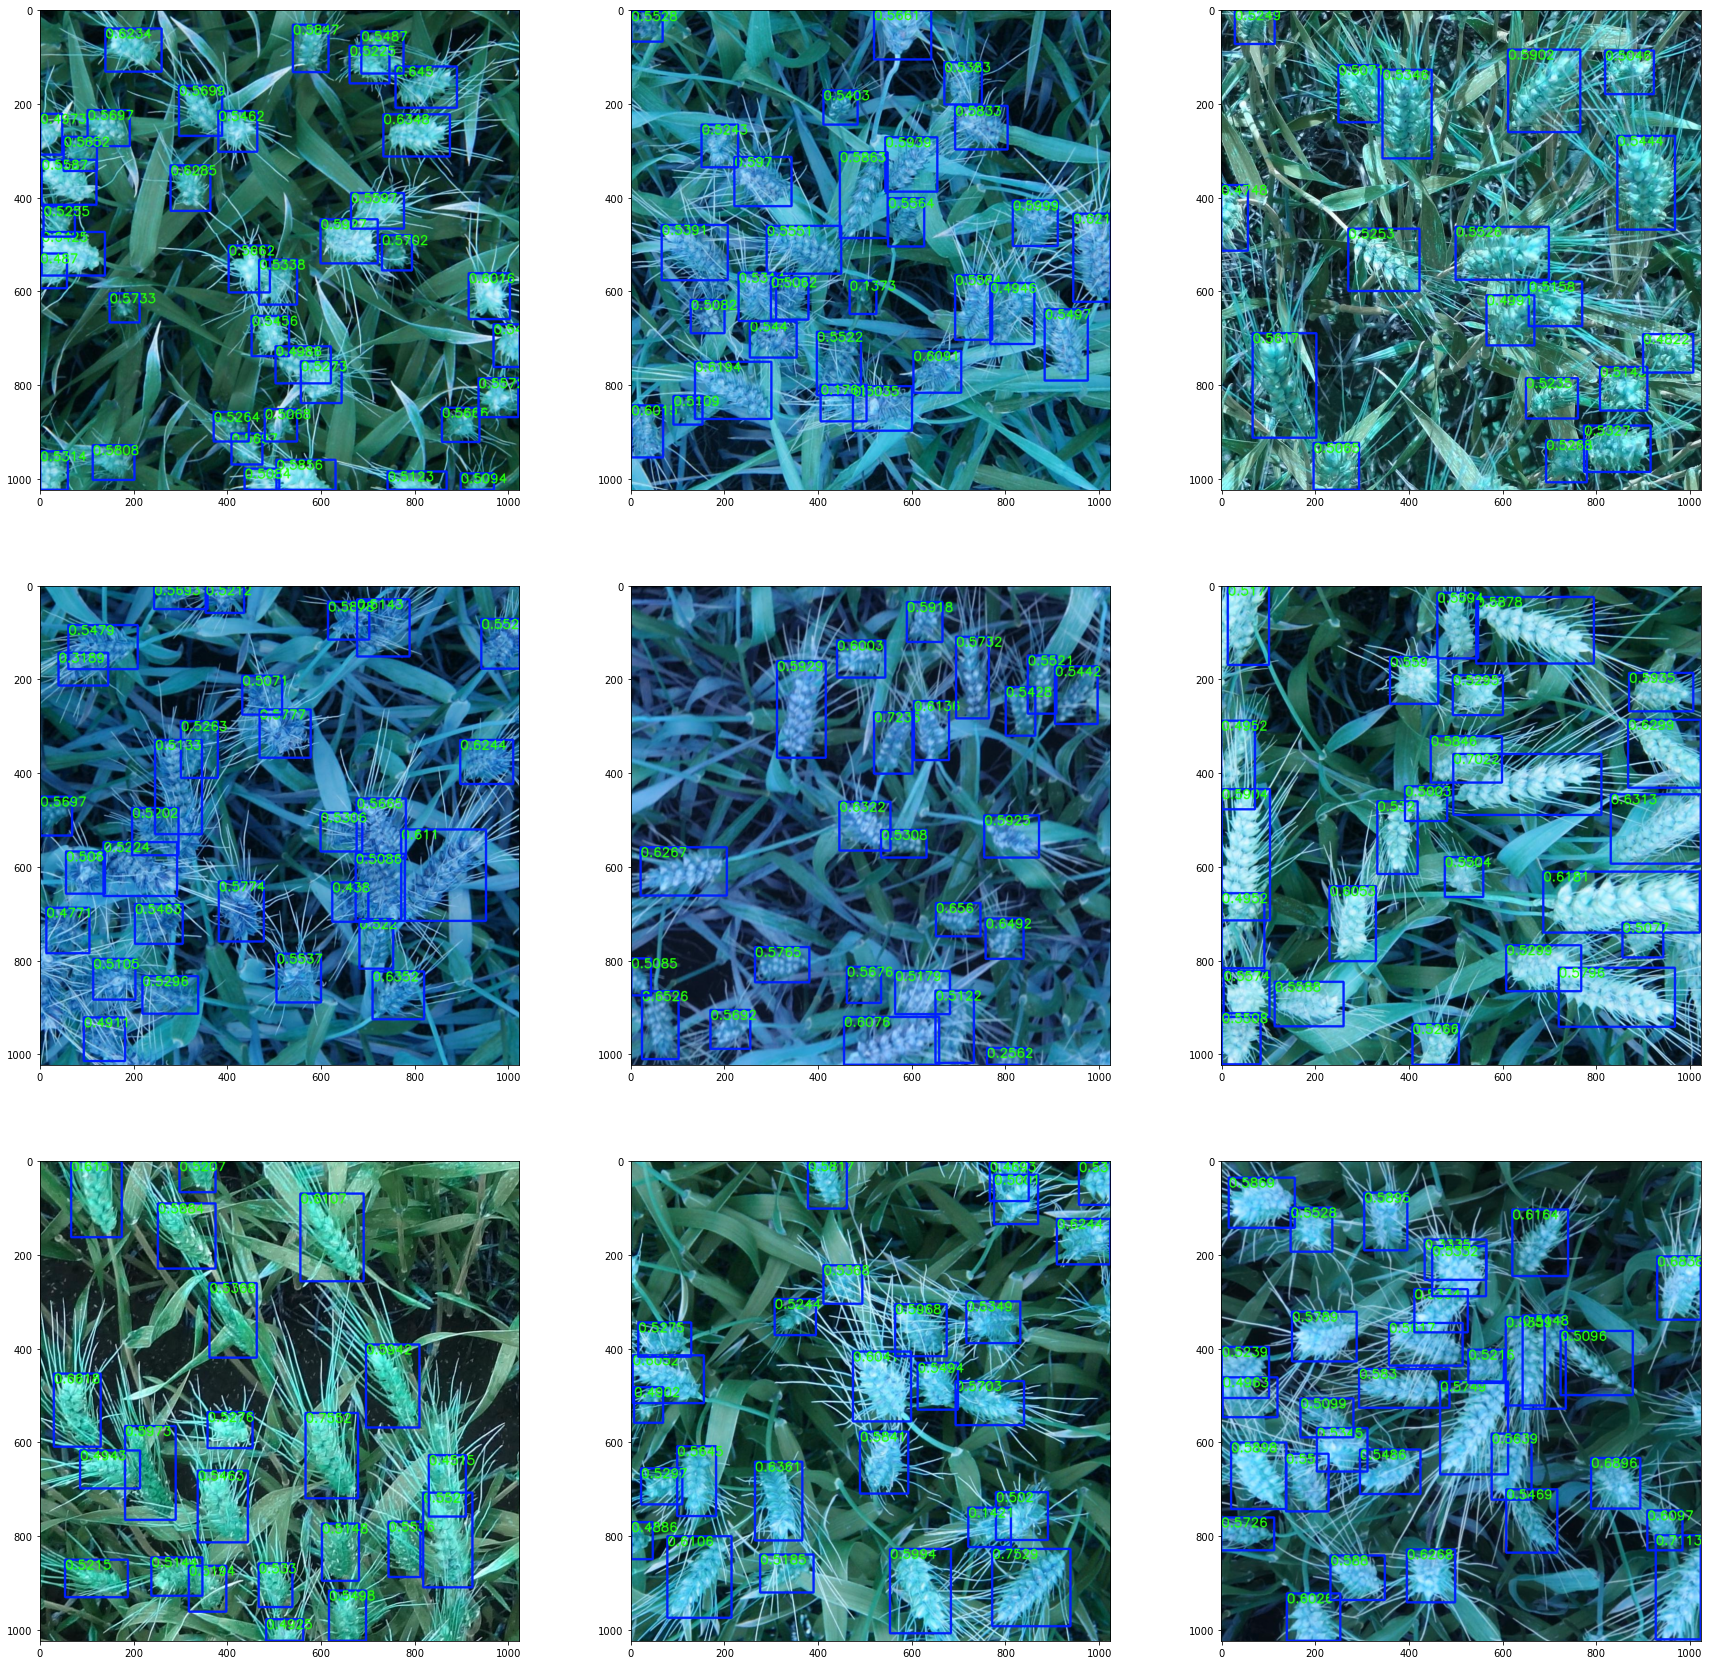

In [ ]:
# test the model
import os

# plot the images
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
# path for the testing images
DIR_TEST = '../input/global-wheat-detection/test'

for i1 in range(3):
    for j1 in range(3):
        num = j1*3 + i1
        img_pth = os.path.join(DIR_TEST, test_df.image_id[num]+'.jpg')
        image = cv2.imread(img_pth)
        b = [float(i) for i in test_df.PredictionString[num].split(' ')]
        
        # store the predicted boxes in a 
        boxes = []
        i = 0
        while i < len(b):
            boxes.append([int(b[i+1]),int(b[i+2]),int(b[i+3]),int(b[i+4]),float(b[i])])
            i+=5
        boxes = np.array(boxes)
        
        for box in boxes.astype(float):
            cv2.rectangle(image,(int(box[0]), int(box[1])),(int(box[0])+int(box[2]),  int(box[1])+int(box[3])),(0, 32, 255), 3)
            cv2.putText(image, str(box[4]), (int(box[0]), int(box[1])+20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        ax[i1][j1].imshow(image)